In [8]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from pysheds.grid import Grid
import pysheds
import numpy as np

In [9]:
import rasterio

input_path = "ASTGTMV003_N30E120/ASTGTMV003_N30E120_dem.tif"
demfile = "hangzhou_dem_fixed.tif"

with rasterio.open(input_path) as src:
    data = src.read(1).astype(np.float32)  # 转为 float32
    profile = src.profile.copy()

    profile.update(dtype=rasterio.float32, nodata=-9999.0)
    
    with rasterio.open(output_path, 'w', **profile) as dst:
        dst.write(data, 1)

In [11]:
# Read raw DEM
grid = Grid.from_raster(demfile)
dem = grid.read_raster(demfile)

# Detect pits
pits = grid.detect_pits(dem)

In [13]:
# Fill pits
pit_filled_dem = grid.fill_pits(dem)
pits = grid.detect_pits(pit_filled_dem)
assert not pits.any()

In [14]:
# Detect depressions
depressions = grid.detect_depressions(pit_filled_dem)

In [15]:
# Fill depressions
flooded_dem = grid.fill_depressions(pit_filled_dem)
depressions = grid.detect_depressions(flooded_dem)
assert not depressions.any()

In [16]:
#Resolving flats
inflated_dem = grid.resolve_flats(flooded_dem)
flats = grid.detect_flats(inflated_dem)
# assert not flats.any()

In [17]:
# Compute flow direction based on corrected DEM
fdir = grid.flowdir(inflated_dem)

# Compute flow accumulation based on computed flow direction
acc = grid.accumulation(fdir)

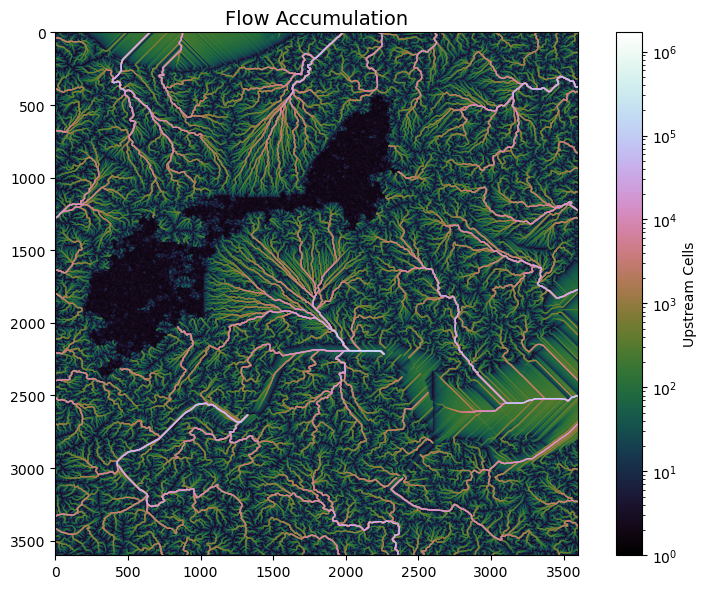

In [18]:
fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)
im = ax.imshow(acc, zorder=2,
               cmap='cubehelix',
               norm=colors.LogNorm(1, acc.max()),
               interpolation='bilinear')
plt.colorbar(im, ax=ax, label='Upstream Cells')
plt.title('Flow Accumulation', size=14)
plt.tight_layout()

In [19]:
# Compute height above nearest drainage
hand = grid.compute_hand(fdir, dem, acc > 200)

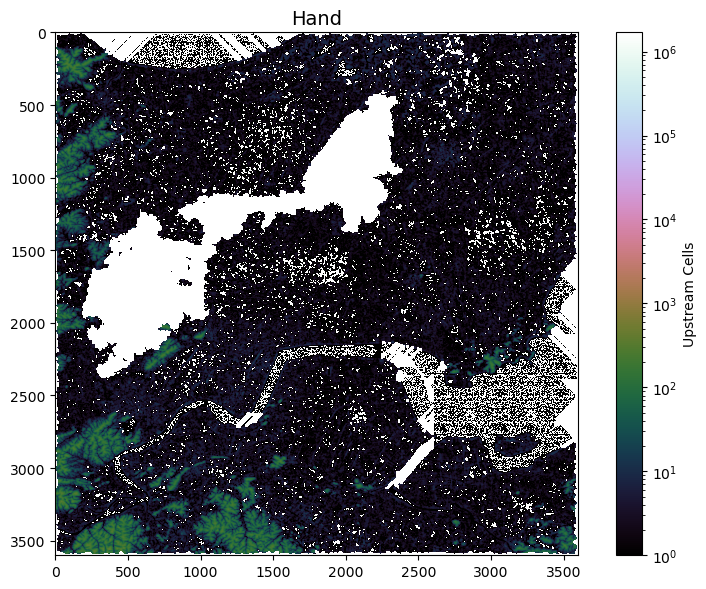

In [20]:
fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)
im = ax.imshow(hand, zorder=2,
               cmap='cubehelix',
               norm=colors.LogNorm(1, acc.max()),
               interpolation='bilinear')
plt.colorbar(im, ax=ax, label='Upstream Cells')
plt.title('Hand', size=14)
plt.tight_layout()

In [21]:
#Estimating inundation extent
threshold = 5
inundation_extent = np.where(hand < threshold, threshold - hand, np.nan)

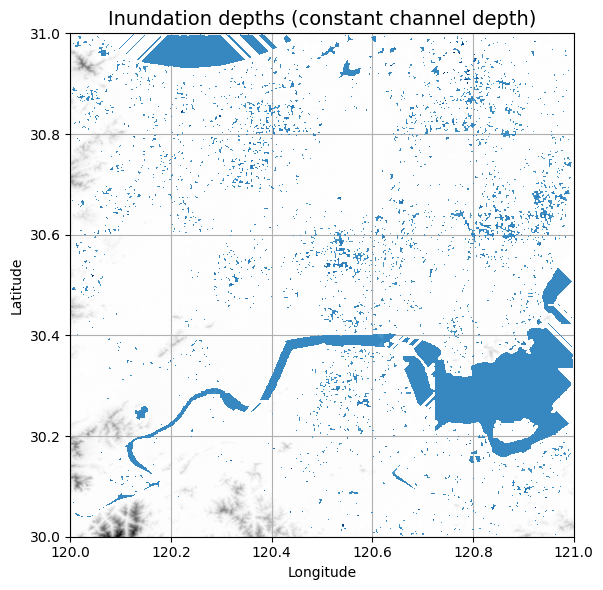

In [22]:
fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)
dem_view = grid.view(dem, nodata=np.nan)
plt.imshow(dem_view, extent=grid.extent, cmap='Greys', zorder=1)
plt.imshow(inundation_extent, extent=grid.extent,
           cmap='Blues', vmin=-5, vmax=10, zorder=2)
plt.grid(zorder=0)
plt.title('Inundation depths (constant channel depth)', size=14)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()